For my assignment this week I wanted to play with Gamma in a simple corridor domain. This work is motivated by "CITE". 

Domain:
The corridor has 10 states in it and the agent starts at the second index. The agent has 3 actions [left, right, exit]. If the agent chooses to exit it receives a 0 reward and the episode terminates. Otherwise the agent receives a -.1 reward at each time step until it reaches the end of the corridor where it receives a +.5 reward if it reaches the left end of the corridor or a +2 reward if it reaches the right end (futher away). 

Optimal Policy?:
One can see that by varying gamma we produce different optimal behavior. For example say the corridor is of length 5 the value of exiting the corridor immediately is 0 and the value of going right until the end is (10 * gamma ^ 4) + (-1 + -1 * gamma + -1 * gamma ^ 2 + -1 * gamma ^ 3). By solving for gamma what our agent deems as optimal really depends on gamma.   

Now say we have a target gamma in mind before we start the experiment, say it is 0.9. 

In [1]:
import numpy as np

class Corridor(object):
    def __init__(self, num_states=20, max_steps=50):
        self.num_states = num_states
        self.state_shape = [num_states]
        self.nb_actions = 3
        self.state = np.zeros((num_states), dtype='float32')
        self.max_steps = max_steps
        self.start_pos = 1
        self.counter = 0
        
    def observe(self):
        return np.copy(self.state) #+ np.random.normal(0, 0.25, self.num_states)

    def _is_over(self, action):
        # exit or max number of steps
        # or \
        # self.state[self.num_states - 1] == 1 or \
        # self.state[0] == 1
        return action == 2 or self.counter >= self.max_steps 

        
    def _update_state(self, action):
        # no-op
        if (action == 0 and self.pos == 0) or (action == 1 and self.pos == self.num_states - 1):  
            pass
        elif action == 0:  # move left
            self.state = np.zeros((self.num_states), dtype='float32')
            self.state[self.pos - 1] = 1
            self.pos -= 1
        elif action == 1:  # move right
            self.state = np.zeros((self.num_states), dtype='float32')
            self.state[self.pos + 1] = 1
            self.pos += 1
        elif action == 2:
            self.state = np.zeros((self.num_states), dtype='float32')
    
    def _get_reward(self, action):
        if action == 2:
            if self.pos == 0:
                reward = 3
            elif self.pos == self.num_states - 1:
                reward = 4
            else:
                reward = - 2 * (self.pos - self.start_pos)
        else:
            reward = 0.0
        return reward
    
    def act(self, action):
        assert action == 0 or action == 1 or action == 2
        reward = self._get_reward(action)
        self._update_state(action)
        game_over = self._is_over(action)
        self.counter += 1
        # #  
        return np.copy(self.state), reward, game_over
        
    def reset(self):
        self.state = np.zeros((self.num_states), dtype='float32')
        self.state[self.start_pos] = 1
        self.pos = self.start_pos
        self.counter = 0

In [2]:
"""
    Tabular Q agent
"""

class Agent(object):
    def __init__(self, state_shape, nb_actions, gamma, lr=1.0):
        self.state_shape = state_shape
        self.nb_actions = nb_actions
        self.gamma = gamma
        self.lr = lr
        self.table = np.ones((state_shape[0], nb_actions)) * 4
    
    def _predict(self, state):
        return self.table[np.argmax(state[0])]
    
    def _train(self, sarst):
        s, a, r, s2, t = sarst
        q = self.table[np.argmax(s)][a]
        target = r + (1 - t) * self.gamma * np.max(self.table[np.argmax(s2)])
        self.table[np.argmax(s)][a] += self.lr * (target - q)

    def get_action(self, state, epsilon):
        if np.random.binomial(1, epsilon):
            return np.random.randint(self.nb_actions)
        else:
            q = self._predict([state])
            return np.argmax(q)

    def learn(self, s, a, r, s2, t):
        return self._train([s, a, r, s2, t])

In [3]:
"""
    Global imports and variables
"""

%matplotlib inline

import numpy as np
import seaborn
import pickle

nb_runs_each = 10
nb_episodes = 50
gammas = [0.5, 0.99]
epsilon = 0.0

In [4]:
"""
    Runs each agent defined by a particular gamma -
    for a fixed number of episodes ("nb_episodes"). 
    Each run is repeated "nb_runs_each" times to compute some measure of variance.
"""

env = Corridor()
agents = [Agent(env.state_shape, env.nb_actions, gamma) for gamma in gammas]
all_agent_cumul_rewards = np.empty((nb_runs_each, nb_episodes, len(agents)))
all_agent_ep_rewards = np.empty((nb_runs_each, nb_episodes, len(agents)))

def do_episode(env, agent, epsilon=1.0, learn=True):
    env.reset()
    terminal = False
    reward = 0
    actions = []
    discount = 1
    gamma = 0.99
    while not terminal:
        s = env.observe()
        a = agent.get_action(s, epsilon=epsilon)
        s2, r, terminal = env.act(a)
        if learn:
            agent.learn(s, a, r, s2, terminal)
        reward += r * discount
        discount *= gamma
        actions.append(a)
    return reward, actions
    
for agent_index, agent in enumerate(agents):
    for run in range(nb_runs_each):
        cumul_rewards = 0
        for ep in range(nb_episodes):
            ep_reward, _ = do_episode(env, agent, epsilon, learn=True)
            cumul_rewards += ep_reward
            all_agent_cumul_rewards[run, ep, agent_index] = cumul_rewards
            all_agent_ep_rewards[run, ep, agent_index] = ep_reward
            
with open('cumul_rewards', 'wb') as f:
    pickle.dump(all_agent_cumul_rewards, f)
with open('ep_rewards', 'wb') as f:
    pickle.dump(all_agent_ep_rewards, f)

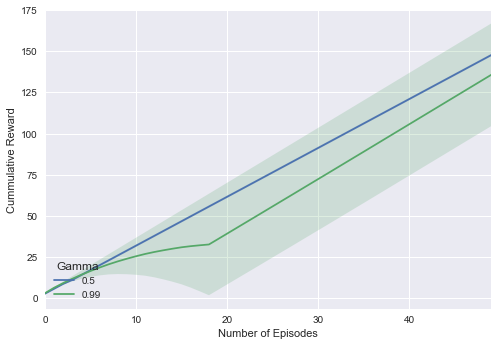

In [5]:
with open('cumul_rewards', 'rb') as f:
     all_agent_cumul_rewards = pickle.load(f)

plot = seaborn.tsplot(data=all_agent_cumul_rewards, legend=True, condition=gammas)
plot.legend(loc='lower left', title='Gamma')
plot.set_ylabel("Cummulative Reward")
plot.set_xlabel("Number of Episodes")

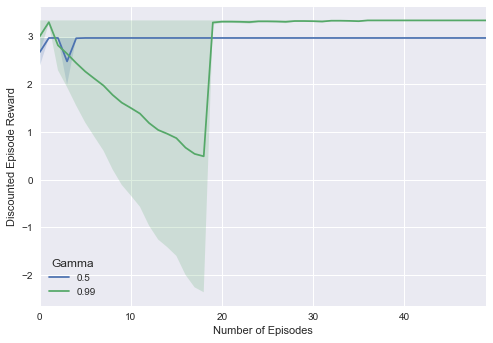

In [6]:
with open('ep_rewards', 'rb') as f:
     all_agent_ep_rewards = pickle.load(f)
        
plot = seaborn.tsplot(data=all_agent_ep_rewards, legend=True, condition=gammas)
plot.legend(loc='lower left', title='Gamma')
plot.set_ylabel("Discounted Episode Reward")
plot.set_xlabel("Number of Episodes")

In [7]:
# view learned polices
int_to_action = ['Left', 'Right', 'Exit']
for agent_index, agent in enumerate(agents):
    reward, actions = do_episode(env, agent, epsilon=0.0)
    action_words = [int_to_action[a] for a in actions]
    print("Gamma = " + str(gammas[agent_index]), "| Actions : ", action_words, "| Reward ", reward) 
    

Gamma = 0.5 | Actions :  ['Left', 'Exit'] | Reward  2.9699999999999998
Gamma = 0.99 | Actions :  ['Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Exit'] | Reward  3.3380550458003495


In [8]:
# LFA
# from keras import backend as K
# from keras.layers import Input
# from keras.layers.core import Dense
# from keras.models import Model
# from keras.optimizers import SGD

#         self.network = build_network(state_shape, nb_actions)
#         self._compile(state_shape, nb_actions)
#         state = np.expand_dims(state.reshape(self.state_shape), axis=0)
#         s = np.expand_dims(s.reshape(self.state_shape), axis=0)
#         s2 = np.expand_dims(s2.reshape(self.state_shape), axis=0)
# def build_network(state_shape, nb_actions):
#     # shared layers
#     input_dim = tuple(state_shape)
#     states = Input(shape=input_dim, dtype='float32', name='states')
#     out = Dense(output_dim=nb_actions, init='zero', activation='linear', bias='False')(states)
#     return Model(input=states, output=out)
#     def _compile(self, state_shape, nb_actions):
#         # Inputs
#         s = K.placeholder(shape=tuple([None] + state_shape))
#         a = K.placeholder(ndim=0, dtype='int32')
#         r = K.placeholder(ndim=0, dtype='float32')
#         s2 = K.placeholder(shape=tuple([None] + state_shape))
#         t = K.placeholder(ndim=0, dtype='float32')

#         # Q(s, a)
#         q = self.network(s)[0]
#         preds = q[a]

#         # r + (1 - t) * gamma * max_a(Q'(s')) for each agent
#         q2 = self.network(s2)[0]
#         q2_max = K.max(q2)
#         targets = r + (K.cast_to_floatx(1) - t) * K.cast_to_floatx(self.gamma) * q2_max

#         # Loss and Updates
#         cost = K.sum(0.5 * (targets - preds) ** 2)
#         optimizer = SGD(lr=self.lr)
#         updates = optimizer.get_updates(params=self.network.trainable_weights, loss=cost, constraints={})

#         # Compiled Functions
#         self._train = K.function(inputs=[s, a, r, s2, t], outputs=[cost], updates=updates)
#         self._predict = K.function(inputs=[s], outputs=q)